# Partie 1 – Visualisation des données et aide à la définition des seuils conditionnels

## Exctracting datas

In [1]:
# import
import sqlite3
import settings as s
import os
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = C:\Users\eva2p\Documents\EFREI\L3\MasterCamp\SolutionDelivery_PRJ\backend\src
MEDIA_ROOT = C:\Users\eva2p\Documents\EFREI\L3\MasterCamp\SolutionDelivery_PRJ\backend\src\media


In [2]:
# Extracting datas
def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'train/with_label/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)


In [3]:
image_data = pd.DataFrame(image_data)
image_data.head(5)

,id_image,File_name,File_path,Size,Height,Width,Date_taken,Avg_R,Avg_G,Avg_B,Contrast_level,RGB_Histogram,Luminance_Histogram,Edges,Status
0,661,WhatsApp Image 2020-05-09 at 2.03.38 PM (1).webp,train/with_label/clean/WhatsApp Image 2020-05-...,67.45,147,123,2025-06-23,54.6144018583043,53.50732813450583,47.586693213870916,34.9224878693443,"{""red"": [57.0, 159.0, 113.0, 63.0, 42.0, 67.0,...","[30.0, 105.0, 92.0, 127.0, 64.0, 82.0, 44.0, 4...",1747,0
1,662,00543_02.webp,train/with_label/clean/00543_02.webp,68.59,181,202,2025-05-28,70.78119358897216,87.71339095235491,76.82864722936382,30.181238847862875,"{""red"": [10.0, 5.0, 8.0, 4.0, 5.0, 8.0, 8.0, 5...","[0.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 6.0, 6.0, ...",3416,0
2,663,WhatsApp Image 2020-05-09 at 2.03.38 PM (3).webp,train/with_label/clean/WhatsApp Image 2020-05-...,51.21,191,191,2025-06-03,140.87604506455415,138.10701461034512,111.22047093007319,42.04006920415628,"{""red"": [19.0, 4.0, 7.0, 18.0, 15.0, 23.0, 29....","[8.0, 27.0, 17.0, 25.0, 36.0, 37.0, 25.0, 68.0...",5626,0
3,664,WhatsApp Image 2020-05-09 at 2.03.37 PM (6).webp,train/with_label/clean/WhatsApp Image 2020-05-...,23.9,308,327,2025-06-13,137.12449859009493,140.56723857182573,122.97168275149926,37.277499848519035,"{""red"": [0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 3.0, 2....","[0.0, 0.0, 3.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, ...",6414,0
4,665,00547_06.webp,train/with_label/clean/00547_06.webp,71.62,101,76,2025-06-04,100.28582595101615,118.5911933298593,108.4471078686816,48.11271796005743,"{""red"": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1801,0


In [4]:
import json
import pandas as pd

# Fonction qui prend la chaîne JSON et renvoie les indices max
def extract_max_indices(hist_str):
    if pd.isna(hist_str):
        return pd.Series([None, None, None], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])
    
    hist = json.loads(hist_str)
    r = max(enumerate(hist["red"]), key=lambda x: x[1])[0]
    g = max(enumerate(hist["green"]), key=lambda x: x[1])[0]
    b = max(enumerate(hist["blue"]), key=lambda x: x[1])[0]
    return pd.Series([r, g, b], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])

# Application de la fonction sur toute la colonne
image_data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = image_data["RGB_Histogram"].apply(extract_max_indices)


In [5]:
def get_max_luminance_index(hist_str):
    if pd.isna(hist_str):
        return None
    hist = json.loads(hist_str)
    return max(range(len(hist)), key=lambda i: hist[i])

# Application de la fonction ligne par ligne
image_data["Max_Lumi_Index"] = image_data["Luminance_Histogram"].apply(get_max_luminance_index)

In [6]:
# Convertir les colonnes en float avant la somme pour éviter la concaténation de chaînes
image_data["sum_rgb"] = image_data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
image_data.drop(columns=["id_image", "File_name", "File_path", "Date_taken", "RGB_Histogram", "Luminance_Histogram", "Height", "Width"], inplace=True)

In [7]:
image_data = image_data.astype(float)

In [8]:
image_empty = image_data[image_data["Status"]==0]
image_full = image_data[image_data["Status"]==1]

In [9]:
image_empty

,Size,Avg_R,Avg_G,Avg_B,Contrast_level,Edges,Status,Max_Red_Index,Max_Green_Index,Max_Blue_Index,Max_Lumi_Index,sum_rgb
0,67.45,54.614402,53.507328,47.586693,34.922488,1747.0,0.0,41.0,47.0,34.0,43.0,155.708423
1,68.59,70.781194,87.713391,76.828647,30.181239,3416.0,0.0,53.0,70.0,68.0,62.0,235.323232
2,51.21,140.876045,138.107015,111.220471,42.040069,5626.0,0.0,139.0,151.0,116.0,142.0,390.203531
3,23.90,137.124499,140.567239,122.971683,37.277500,6414.0,0.0,135.0,148.0,120.0,141.0,400.663420
4,71.62,100.285826,118.591193,108.447108,48.112718,1801.0,0.0,66.0,88.0,71.0,83.0,327.324127
5,82.88,97.119669,93.185190,79.703868,61.719640,2272.0,0.0,49.0,45.0,41.0,49.0,270.008727
6,69.07,87.984903,96.713595,82.804098,27.533588,3169.0,0.0,116.0,118.0,116.0,119.0,267.502596
7,28.85,79.909373,98.675720,73.190966,36.983625,2500.0,0.0,66.0,90.0,58.0,79.0,251.776059
8,57.77,118.747299,122.425302,116.477254,40.878619,10941.0,0.0,76.0,84.0,73.0,78.0,357.649855
9,48.39,98.923307,97.403280,80.507073,44.664811,7258.0,0.0,64.0,68.0,42.0,65.0,276.833661


In [24]:
image_full

,Size,Avg_R,Avg_G,Avg_B,Contrast_level,Edges,Status,Max_Red_Index,Max_Green_Index,Max_Blue_Index,Max_Lumi_Index,sum_rgb,x
20,20.95,85.657230,84.651746,76.616719,46.370797,3936.0,1.0,33.0,36.0,29.0,36.0,246.925695,0
21,147.83,102.053506,105.694906,104.585450,51.893217,34082.0,1.0,34.0,46.0,255.0,42.0,312.333862,1
22,23.42,117.227889,115.300963,102.706963,52.643385,5273.0,1.0,100.0,137.0,51.0,70.0,335.235815,2
23,66.29,57.141301,65.262398,72.684335,22.898666,990.0,1.0,39.0,60.0,61.0,55.0,195.088035,3
24,844.13,112.940772,114.095108,119.761209,61.746798,281461.0,1.0,53.0,67.0,255.0,56.0,346.797088,4
25,25.61,77.425551,78.688628,82.971165,63.282270,10267.0,1.0,9.0,21.0,44.0,19.0,239.085343,5
26,2707.42,114.157412,112.879243,100.581154,58.189927,234330.0,1.0,65.0,84.0,39.0,141.0,327.617809,6
27,6458.14,118.753190,122.341745,116.088288,59.914149,983423.0,1.0,178.0,157.0,255.0,177.0,357.183222,7
28,35.49,106.305424,109.237340,105.670377,43.494432,15983.0,1.0,104.0,119.0,84.0,112.0,321.213140,8
29,112.53,84.413826,83.859335,87.847095,51.051383,6422.0,1.0,36.0,56.0,47.0,55.0,256.120257,9


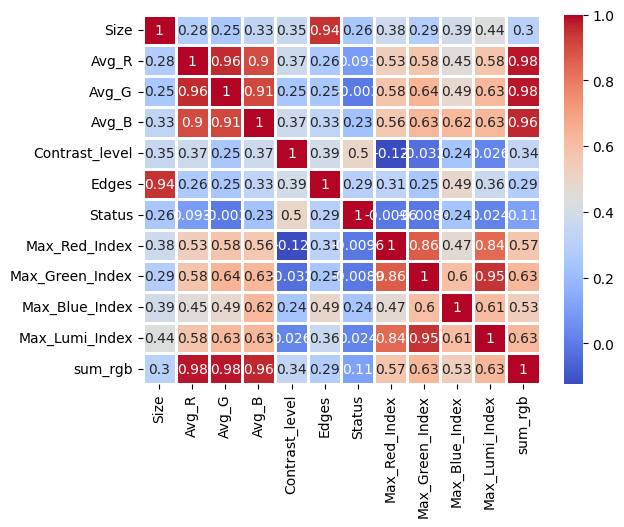

In [10]:
corr = image_data.corr ()
sns.heatmap(corr, cmap='coolwarm', annot = True, linewidth =0.9)
plt.show()

**Analyse :** On va utiliser les variables avec une correlation superieure à 0.2 

## Rules Tuning

In [11]:
def fit_polynomial(df, x_col, y_col, degree=2):
    """
    Ajuste une régression polynomiale sur tout le DataFrame et renvoie une fonction polynomiale utilisable.
    
    Args:
        df (pd.DataFrame): Tableau avec les données.
        x_col (str): Nom de la colonne x.
        y_col (str): Nom de la colonne y.
        degree (int): Degré du polynôme.
        
    Returns:
        np.poly1d: La fonction polynomiale.
    """
    coefs = n.polyfit(df[x_col], df[y_col], deg=degree)
    poly_fn = n.poly1d(coefs)
    return poly_fn

image_empty["x"] = n.arange(len(image_empty["Edges"]))
image_full["x"] = n.arange(len(image_full["Edges"]))



C:\Users\eva2p\AppData\Local\Temp\ipykernel_41124\1616423379.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_empty["x"] = n.arange(len(image_empty["Edges"]))
C:\Users\eva2p\AppData\Local\Temp\ipykernel_41124\1616423379.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_full["x"] = n.arange(len(image_full["Edges"]))


### Edges

In [12]:
s = {
    'count': image_empty["Edges"].count(),
    'min': image_empty["Edges"].min(),
    'max': image_empty["Edges"].max(),
    'median': image_empty["Edges"].median(),
    'mean': image_empty["Edges"].mean(),
    'std': image_empty["Edges"].std()
}

print("Edges - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_full["Edges"].count(),
    'min': image_full["Edges"].min(),
    'max': image_full["Edges"].max(),
    'median': image_full["Edges"].median(),
    'mean': image_full["Edges"].mean(),
    'std': image_full["Edges"].std()
}

print("\nEdges - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Edges - Empty
Count   : 20
Min     : 759.0
Max     : 48779.0
Median  : 3521.5
Mean    : 7549.9
Std     : 10957.067178189995

Edges - Full
Count   : 20
Min     : 990.0
Max     : 983423.0
Median  : 15724.5
Mean    : 102565.65
Std     : 223361.91124396137


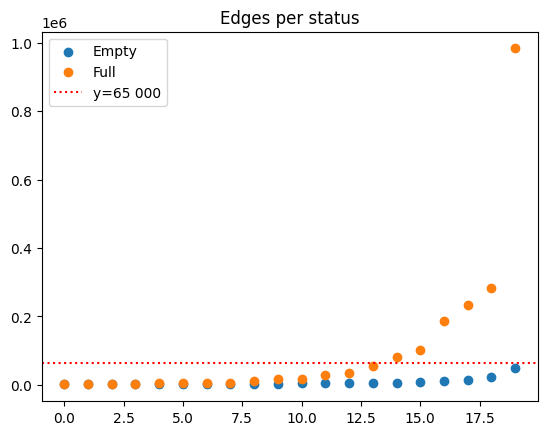

In [13]:
plt.scatter(image_empty["x"], sorted(image_empty["Edges"]), label="Empty")
plt.scatter(image_full["x"], sorted(image_full["Edges"]), label="Full")
plt.axhline(y=65000, color='red', linestyle=':', label='y=65 000')
plt.title("Edges per status")
plt.legend()
plt.show()

L'utilisation de la regréssion polynomiale ne sera malheureusement pas utilisée sous la contrainte du cahier des charges.

### Size

In [14]:
s = {
    'count': image_full["Size"].count(),
    'min': image_full["Size"].min(),
    'max': image_full["Size"].max(),
    'median': image_full["Size"].median(),
    'mean': image_full["Size"].mean(),
    'std': image_full["Size"].std()
}
print("Size - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Size"].count(),
    'min': image_empty["Size"].min(),
    'max': image_empty["Size"].max(),
    'median': image_empty["Size"].median(),
    'mean': image_empty["Size"].mean(),
    'std': image_empty["Size"].std()
}
print("Size - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Size - Full
Count   : 20
Min     : 20.95
Max     : 6458.14
Median  : 68.98
Mean    : 730.794
Std     : 1524.2758680812135
Size - Empty
Count   : 20
Min     : 23.9
Max     : 1821.85
Median  : 63.870000000000005
Mean    : 152.734
Std     : 394.35618312970774


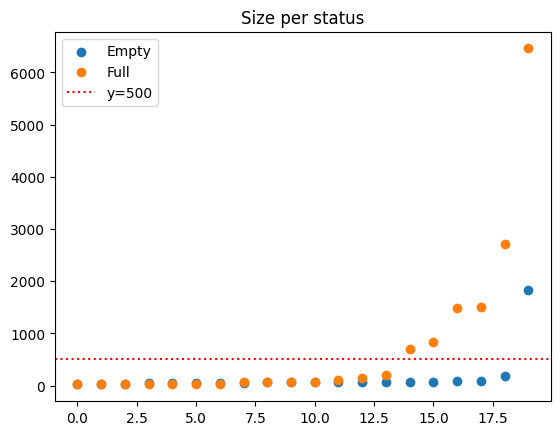

In [15]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
size_empty = image_empty["Size"].astype(float)
size_full = image_full["Size"].astype(float)

plt.scatter(n.arange(len(size_empty)), sorted(size_empty), label="Empty")
plt.scatter(n.arange(len(size_full)), sorted(size_full), label="Full")
plt.axhline(y=500, color='red', linestyle=':', label='y=500')
plt.title("Size per status")
plt.legend()
plt.show()

### Avg_B

In [16]:
s = {
    'count': image_full["Avg_B"].count(),
    'min': image_full["Avg_B"].min(),
    'max': image_full["Avg_B"].max(),
    'median': image_full["Avg_B"].median(),
    'mean': image_full["Avg_B"].mean(),
    'std': image_full["Avg_B"].std()
}
print("Avg_B - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Avg_B"].count(),
    'min': image_empty["Avg_B"].min(),
    'max': image_empty["Avg_B"].max(),
    'median': image_empty["Avg_B"].median(),
    'mean': image_empty["Avg_B"].mean(),
    'std': image_empty["Avg_B"].std()
}
print("Avg_B - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Avg_B - Full
Count   : 20
Min     : 56.84104938271605
Max     : 126.92037264593803
Median  : 101.64405839721911
Mean    : 96.80222819244352
Std     : 19.190843514581967
Avg_B - Empty
Count   : 20
Min     : 47.586693213870916
Max     : 122.97168275149926
Median  : 80.10547040693126
Mean    : 87.7023583620643
Std     : 20.81830671669962


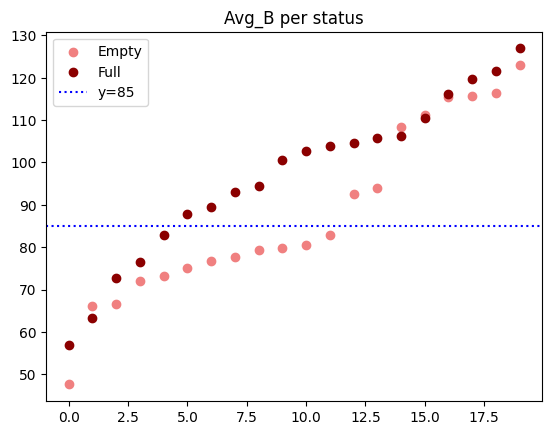

In [17]:
avg_b_empty = image_empty["Avg_B"].astype(float)
avg_b_full = image_full["Avg_B"].astype(float)
plt.scatter(n.arange(len(avg_b_empty)), sorted(avg_b_empty), label="Empty", color='lightcoral')
plt.scatter(n.arange(len(avg_b_full)), sorted(avg_b_full), label="Full", color='darkred')
plt.axhline(y=85, color='blue', linestyle=':', label='y=85')
plt.title("Avg_B per status")
plt.legend()
plt.show()

### Max_Blue_index

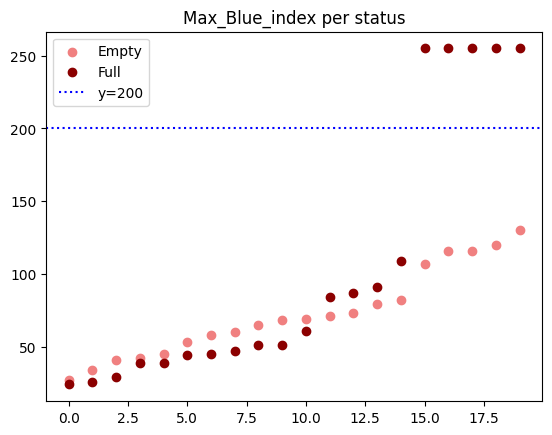

In [18]:
max_blue_empty = image_empty["Max_Blue_Index"].astype(float)
max_blue_full = image_full["Max_Blue_Index"].astype(float)
plt.scatter(n.arange(len(max_blue_empty)), sorted(max_blue_empty), label="Empty", color='lightcoral')
plt.scatter(n.arange(len(max_blue_full)), sorted(max_blue_full), label="Full", color='darkred')
plt.axhline(y=200, color='blue', linestyle=':', label='y=200')
plt.title("Max_Blue_index per status")
plt.legend()
plt.show()

### Contrast_level

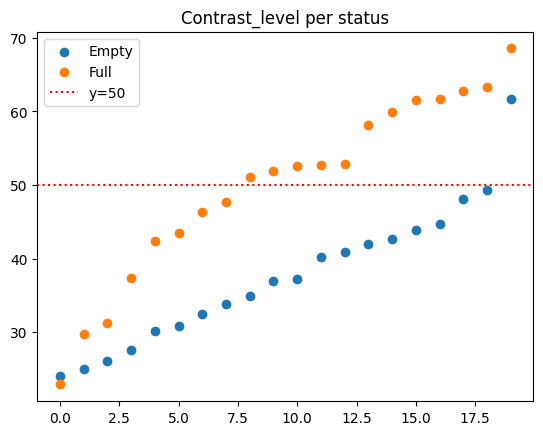

In [19]:
contrast_empty = image_empty["Contrast_level"].astype(float)
contrast_full = image_full["Contrast_level"].astype(float)

plt.scatter(n.arange(len(contrast_empty)), sorted(contrast_empty), label="Empty")
plt.scatter(n.arange(len(contrast_full)), sorted(contrast_full), label="Full")
plt.axhline(y=50, color='red', linestyle=':', label='y=50')
plt.title("Contrast_level per status")
plt.legend()
plt.show()


# Conditional Model

In [20]:

# Exemple de structure de règle : 

rules = [{"feature": "Size", "operator": ">", "threshold": 500, "score": 0.26},
         {"feature": "Avg_B", "operator": ">", "threshold": 85, "score": 0.23/2},
         {"feature": "Contrast_level", "operator": ">", "threshold": 50, "score": 0.5},
         {"feature": "Edges", "operator": ">", "threshold": 65000, "score": 0.29},
         {"feature": "Max_Blue_Index", "operator": ">", "threshold": 200, "score": 0.24/2} # diviser par deux car redondant.
        ]

def apply_rule(row, rule):
    if rule["operator"] == ">":
        return row[rule["feature"]] > rule["threshold"]
    elif rule["operator"] == "<":
        return row[rule["feature"]] < rule["threshold"]
    elif rule["operator"] == ">=":
        return row[rule["feature"]] >= rule["threshold"]
    elif rule["operator"] == "<=":
        return row[rule["feature"]] <= rule["threshold"]
    elif rule["operator"] == "==":
        return row[rule["feature"]] == rule["threshold"]
    else:
        return False

def predict_status(data, rules, threshold_score=0.4):
    # return True == status full
    predictions = []
    for _, row in data.iterrows():
        print(row)
        print(rules)
        score = 0
        for rule in rules:
            if apply_rule(row, rule):
                score += rule["score"]
        predicted_status = 1 if score >= threshold_score else 0
        predictions.append(predicted_status)
    return predictions


# Model test - classification metrics

#### Train

In [21]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


image_data["Predicted_Status"] = predict_status(image_data, rules, threshold_score=0.2)

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Matrice de confusion:", confusion_matrix(y_true, y_pred))
print("Rapport de classification:", classification_report(y_true, y_pred))


Size                 67.450000
Avg_R                54.614402
Avg_G                53.507328
Avg_B                47.586693
Contrast_level       34.922488
Edges              1747.000000
Status                0.000000
Max_Red_Index        41.000000
Max_Green_Index      47.000000
Max_Blue_Index       34.000000
Max_Lumi_Index       43.000000
sum_rgb             155.708423
Name: 0, dtype: float64
[{'feature': 'Size', 'operator': '>', 'threshold': 500, 'score': 0.26}, {'feature': 'Avg_B', 'operator': '>', 'threshold': 85, 'score': 0.115}, {'feature': 'Contrast_level', 'operator': '>', 'threshold': 50, 'score': 0.5}, {'feature': 'Edges', 'operator': '>', 'threshold': 65000, 'score': 0.29}, {'feature': 'Max_Blue_Index', 'operator': '>', 'threshold': 200, 'score': 0.12}]
Size                 68.590000
Avg_R                70.781194
Avg_G                87.713391
Avg_B                76.828647
Contrast_level       30.181239
Edges              3416.000000
Status                0.000000
Max_Red_I

#### Test

In [22]:
# Exctracting test datas
import settings as s
def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'test/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)
image_data = pd.DataFrame(image_data)
image_data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = image_data["RGB_Histogram"].apply(extract_max_indices)
image_data["sum_rgb"] = image_data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
image_data.drop(columns=["id_image", "File_name", "File_path", "Date_taken", "RGB_Histogram", "Luminance_Histogram", "Height", "Width"], inplace=True)
image_data = image_data.astype(float)

In [23]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


image_data["Predicted_Status"] = predict_status(image_data, rules, threshold_score=0.2)

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Matrice de confusion:", confusion_matrix(y_true, y_pred))
print("Rapport de classification:", classification_report(y_true, y_pred))


Size                  71.120000
Avg_R                107.200811
Avg_G                100.404856
Avg_B                 83.947162
Contrast_level        31.202831
Edges              11332.000000
Status                 0.000000
Max_Red_Index        135.000000
Max_Green_Index      115.000000
Max_Blue_Index        97.000000
sum_rgb              291.552829
Name: 0, dtype: float64
[{'feature': 'Size', 'operator': '>', 'threshold': 500, 'score': 0.26}, {'feature': 'Avg_B', 'operator': '>', 'threshold': 85, 'score': 0.115}, {'feature': 'Contrast_level', 'operator': '>', 'threshold': 50, 'score': 0.5}, {'feature': 'Edges', 'operator': '>', 'threshold': 65000, 'score': 0.29}, {'feature': 'Max_Blue_Index', 'operator': '>', 'threshold': 200, 'score': 0.12}]
Size                 257.540000
Avg_R                 89.464031
Avg_G                 94.143989
Avg_B                 80.153586
Contrast_level        38.790453
Edges              37144.000000
Status                 1.000000
Max_Red_Index         

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from itertools import product

# --- Fonction d'application d'une règle ---
def apply_rule(row, rule):
    feature_value = row[rule["feature"]]
    threshold = rule["threshold"]
    operator = rule["operator"]
    if operator == ">":
        return feature_value > threshold
    elif operator == "<":
        return feature_value < threshold
    elif operator == ">=":
        return feature_value >= threshold
    elif operator == "<=":
        return feature_value <= threshold
    elif operator == "==":
        return feature_value == threshold
    else:
        raise ValueError(f"Unsupported operator: {operator}")

# --- Prédiction avec score cumulatif ---
def predict_status(data, rules, threshold_score=0.4):
    predictions = []
    for _, row in data.iterrows():
        score = 0
        for rule in rules:
            if apply_rule(row, rule):
                score += rule["score"]
        predicted_status = 1 if score >= threshold_score else 0
        predictions.append(predicted_status)
    return predictions

# --- Évaluation avec précision uniquement (pour tuning) ---
def evaluate_model(data, rules, threshold_score=0.4):
    predictions = predict_status(data, rules, threshold_score)
    true_labels = data["Status"].astype(int).values
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# --- Espaces de recherche pour chaque feature ---
threshold_ranges = {
    "Size": [24.1, 59.7, 102.7, 132.4, 150, 170, 200, 310, 350, 500, 1000, 2000, 4000, 6000],
    "Avg_B": [48.2, 52.6, 57.8, 61.4, 66.7, 70.3, 75.0, 80.6, 85.9, 90.2, 95, 105, 120],
    "Contrast_level": [25, 35, 40, 45, 50, 55, 60],
    "Edges": [760, 2100, 4200, 22700, 41000, 62000, 83000, 144000, 481000, 673000],
    "Max_Blue_Index": [30, 70, 110, 150, 180, 210, 240]
}

score_ranges = [0.1, 0.2, 0.3, 0.4]
threshold_score_values = [0.3, 0.4, 0.5]

# --- Meilleur résultat à stocker ---
best_accuracy = 0
best_config = None

# --- Produit cartésien en lazy evaluation ---
combination_generator = product(
    threshold_ranges["Size"],
    threshold_ranges["Avg_B"],
    threshold_ranges["Contrast_level"],
    threshold_ranges["Edges"],
    threshold_ranges["Max_Blue_Index"],
    score_ranges, score_ranges, score_ranges, score_ranges, score_ranges,
    threshold_score_values
)

# --- Boucle d’évaluation ---
print("Début de la recherche des meilleures combinaisons...\n")

for i, combo in enumerate(combination_generator):
    thresholds = combo[:5]
    scores = combo[5:10]
    threshold_score = combo[10]

    rules = [
        {"feature": "Size", "operator": ">", "threshold": thresholds[0], "score": scores[0]},
        {"feature": "Avg_B", "operator": ">", "threshold": thresholds[1], "score": scores[1]},
        {"feature": "Contrast_level", "operator": ">", "threshold": thresholds[2], "score": scores[2]},
        {"feature": "Edges", "operator": ">", "threshold": thresholds[3], "score": scores[3]},
        {"feature": "Max_Blue_Index", "operator": ">", "threshold": thresholds[4], "score": scores[4]}
    ]

    acc = evaluate_model(image_data, rules, threshold_score)

    if acc > best_accuracy:
        best_accuracy = acc
        best_config = {
            "rules": rules,
            "threshold_score": threshold_score,
            "accuracy": acc
        }

    if i % 500 == 0:
        print(f"Testé {i} combinaisons — Meilleure accuracy actuelle : {best_accuracy:.4f}")

    # (Optionnel) Limiter à un certain nombre de tests
    # if i > 5000:
    #     break

print("\n--- Meilleure configuration trouvée ---")
print(best_config)

# --- Évaluation complète avec les métriques finales ---
print("\n--- Évaluation détaillée avec les meilleures règles ---")

final_predictions = predict_status(image_data, best_config["rules"], best_config["threshold_score"])
image_data["Predicted_Status"] = final_predictions

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall:", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_true, y_pred, zero_division=0))
print("\nMatrice de confusion:\n", confusion_matrix(y_true, y_pred))
print("\nRapport de classification:\n", classification_report(y_true, y_pred, zero_division=0))


Début de la recherche des meilleures combinaisons...

Testé 0 combinaisons — Meilleure accuracy actuelle : 0.4900
Testé 500 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 1000 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 1500 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 2000 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 2500 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 3000 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 3500 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 4000 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 4500 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 5000 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 5500 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 6000 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 6500 combinaisons — Meilleure accuracy actuelle : 0.5400
Testé 7000 combinaisons — Meilleure accuracy actuelle : 0.5400
Testé

KeyboardInterrupt: 

C'était trop long donc nous avons stoppé le script mais on remarque une bonne accuracy à 0,69.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from itertools import product
from math import prod

# --- Fonction d'application d'une règle ---
def apply_rule(row, rule):
    feature_value = row[rule["feature"]]
    threshold = rule["threshold"]
    operator = rule["operator"]
    if operator == ">":
        return feature_value > threshold
    elif operator == "<":
        return feature_value < threshold
    elif operator == ">=":
        return feature_value >= threshold
    elif operator == "<=":
        return feature_value <= threshold
    elif operator == "==":
        return feature_value == threshold
    else:
        raise ValueError(f"Unsupported operator: {operator}")

# --- Prédiction avec score cumulatif ---
def predict_status(data, rules, threshold_score=0.4):
    predictions = []
    for _, row in data.iterrows():
        score = 0
        for rule in rules:
            if apply_rule(row, rule):
                score += rule["score"]
        predicted_status = 1 if score >= threshold_score else 0
        predictions.append(predicted_status)
    return predictions

# --- Évaluation avec précision uniquement (pour tuning) ---
def evaluate_model(data, rules, threshold_score=0.4):
    predictions = predict_status(data, rules, threshold_score)
    true_labels = data["Status"].astype(int).values
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# --- Espaces de recherche pour chaque feature ---
threshold_ranges = {
    "Size": [102.7, 132.4, 150, 170, 200, 310, 350, 500, 1000, 2000, 4000],
    "Avg_B": [48.2, 57.8, 61.4, 66.7, 70.3, 75.0, 80.6, 85.9, 90.2, 105, 120],
    "Contrast_level": [35, 40, 45, 50, 55, 60],
    "Edges": [760, 2100, 4200, 22700, 41000, 62000, 83000, 144000, 481000, 673000],
    "Max_Blue_Index": [30, 100, 150, 190, 240]
}

score_ranges = [0.1, 0.2, 0.3, 0.4]
threshold_score_values = [0.3, 0.4, 0.5]

# --- Calcul du nombre total de combinaisons ---
threshold_lengths = [len(threshold_ranges[k]) for k in threshold_ranges]
num_score_combos = len(score_ranges) ** 5
num_threshold_scores = len(threshold_score_values)
total_combinations = prod(threshold_lengths) * num_score_combos * num_threshold_scores
print(f"Nombre total de combinaisons à tester : {total_combinations:,}\n")


Nombre total de combinaisons à tester : 273,960,960



In [30]:
# --- Meilleur résultat à stocker ---
best_accuracy = 0
best_config = None

# --- Produit cartésien ---
combination_generator = product(
    threshold_ranges["Size"],
    threshold_ranges["Avg_B"],
    threshold_ranges["Contrast_level"],
    threshold_ranges["Edges"],
    threshold_ranges["Max_Blue_Index"],
    score_ranges, score_ranges, score_ranges, score_ranges, score_ranges,
    threshold_score_values
)

# --- Boucle d’évaluation ---
print("Début de la recherche des meilleures combinaisons...\n")

for i, combo in enumerate(combination_generator):
    thresholds = combo[:5]
    scores = combo[5:10]
    threshold_score = combo[10]

    rules = [
        {"feature": "Size", "operator": ">", "threshold": thresholds[0], "score": scores[0]},
        {"feature": "Avg_B", "operator": ">", "threshold": thresholds[1], "score": scores[1]},
        {"feature": "Contrast_level", "operator": ">", "threshold": thresholds[2], "score": scores[2]},
        {"feature": "Edges", "operator": ">", "threshold": thresholds[3], "score": scores[3]},
        {"feature": "Max_Blue_Index", "operator": ">", "threshold": thresholds[4], "score": scores[4]}
    ]

    acc = evaluate_model(image_data, rules, threshold_score)

    if acc > best_accuracy:
        best_accuracy = acc
        best_config = {
            "rules": rules,
            "threshold_score": threshold_score,
            "accuracy": acc
        }

    if i % 500 == 0:
        print(f"Testé {i:,} combinaisons — Meilleure accuracy actuelle : {best_accuracy:.4f}")

    # Arrêt automatique si l'on atteint un score satisfaisant
    if best_accuracy >= 0.69:
        print(f"\n🛑 Arrêt anticipé à {i + 1:,} combinaisons — Accuracy atteinte : {best_accuracy:.4f}")
        break

    # --- Limiter manuellement (optionnel) ---
    # if i > 10000:
    #     break

# --- Affichage des meilleurs résultats ---
print("\n--- Meilleure configuration trouvée ---")
print(best_config)

# --- Évaluation complète ---
print("\n--- Évaluation détaillée avec les meilleures règles ---")

final_predictions = predict_status(image_data, best_config["rules"], best_config["threshold_score"])
image_data["Predicted_Status"] = final_predictions

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, zero_division=0))
print("Recall:", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_true, y_pred, zero_division=0))
print("\nMatrice de confusion:\n", confusion_matrix(y_true, y_pred))
print("\nRapport de classification:\n", classification_report(y_true, y_pred, zero_division=0))

Début de la recherche des meilleures combinaisons...

Testé 0 combinaisons — Meilleure accuracy actuelle : 0.4900
Testé 500 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 1,000 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 1,500 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 2,000 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 2,500 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 3,000 combinaisons — Meilleure accuracy actuelle : 0.5100
Testé 3,500 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 4,000 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 4,500 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 5,000 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 5,500 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 6,000 combinaisons — Meilleure accuracy actuelle : 0.5200
Testé 6,500 combinaisons — Meilleure accuracy actuelle : 0.5400
Testé 7,000 combinaisons — Meilleure accuracy actuelle :